# Análisis de los datos
En este notebook, se realiza un análisis  de los datos procesados obtenidos de los archivos de video y los ángulos calculados entre los keypoints. El objetivo es extraer información  y realizar una  detallada de los movimientos y posturas de los sujetos durante la ejecución de los gestos mediante gráficas.

**Objetivo**
* Genertar gráficos y diagramas que ilustran la distribución de los ángulos, comparaciones entre diferentes gestos y sujetos, y otros hallazgos relevantes del análisis.

**Entrada**
* ``Resultados/raw_pacientes.csv``: Contiene información detallada sobre cada grabación, incluyendo detalles del paciente, repeticiones, IDs de movimiento y posiciones de keypoints.
* ``Resultados/angles.csv``: Incluye los ángulos calculados entre keypoints, proporcionando datos clave para el análisis de la postura y el movimiento durante los gestos.
Estas son los archivos de salida de ``leer_dataset.ipynb``.

**Índice**
1. [Posición de un keypoint a través del tiempo](#1-posición-de-un-keypoint-a-través-del-tiempo)
2. [Número de instancias correctas e incorrectas](#2-numero-de-instancias-correctas-e-incorrectas)
3. [Sujetos por gesto](#3-sujetos-por-gesto)
4. [Sujetos por gesto y estado de ejecución](#4-sujetos-por-gesto-y-estado-de-ejecución)
5. [Ángulos a través del tiempo](#5-ángulos-a-través-de-tiempo)
****

In [1]:
# importar librerias necesarias
import pandas as pd # para manejar dataframes
# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
# dataframe con toda la informacion recompilada de RawData
df_data = pd.read_csv('../Resultados/raw_pacientes.csv', dtype=object) # salida de leer_dataset.ipynb
df_data.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,GestureName,RepetitionNumber,CorrectLabel,Position,JointName,3D_X,3D_Y,3D_Z
0,101,0,EFL,1,1,stand,SpineBase,-0.1028086,0.06965441,2.464606
1,101,0,EFL,1,1,stand,SpineMid,-0.1026228,0.3837799,2.438919
2,101,0,EFL,1,1,stand,Neck,-0.1025293,0.6877351,2.40196
3,101,0,EFL,1,1,stand,Head,-0.1190992,0.8358598,2.373549
4,101,0,EFL,1,1,stand,ShoulderLeft,-0.2826451,0.5525576,2.38421


In [3]:
# dataframe de los ángulos
df_angle = pd.read_csv('../Resultados/angles.csv', dtype=object) # salida de leer_dataset.ipynb
df_angle.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,GestureName,RepetitionNumber,CorrectLabel,Position,ElbowAngleLeft,ElbowAngleRight,ShoulderAngleLeft,ShoulderAngleRight,...,WristAngleRight,HipAngleLeft,KneeAngleLeft,AnkleAngleLeft,HipAngleRight,KneeAngleRight,AnkleAngleRight,LeftArmAngle,RightArmAngle,ArmsTogetherAngle
0,101,0,EFL,1,1,stand,18.731843936650424,12.815118946951435,142.56072708652192,140.8571426387537,...,6.344405637608901,104.5747679730094,3.7435506773061333,64.24626053705715,101.52185041599935,4.855627354351335,60.940986210135996,156.79111229969607,159.877407693405,152.5802699744159
1,101,0,EFL,1,1,stand,18.682010755659054,13.214648067770003,142.7577595466217,140.9677208312887,...,5.905770832550968,104.49919472393678,3.8218023488309028,64.33472935259476,101.59042532461358,4.885455773565752,61.134581500479065,156.6678130863767,160.03520258395608,152.60252680100132
2,101,0,EFL,1,1,stand,18.530184262036656,14.175895064520457,142.7247948799034,140.88609375865042,...,6.639702926066894,104.55811872843174,3.8325701798137515,64.07890086662397,101.49209376606214,4.776420751381912,59.97208176790675,156.7471314836981,160.25176387076863,152.59651349643386
3,101,0,EFL,1,1,stand,18.525440977960322,15.675640279915678,142.79622290883253,140.9968189243439,...,10.172813641210128,104.50249858755312,3.642045853947008,63.451165579610276,101.4229465647835,4.655746650709144,59.36623122144632,156.7156146991269,160.58950237088143,152.65336196960283
4,101,0,EFL,1,1,stand,18.440643919913423,18.67249056716455,142.75501899334424,140.9860298960347,...,9.700974734790202,104.55404594109505,3.6707316236153287,63.21274018000994,101.31100108996237,4.601471721779157,59.328042932406,156.7934840564589,160.6683059545748,152.67563978301823


****
## 1. Posición de un keypoint a través del tiempo

Posición de la muñeca de una persona sana (102) vs un paciente (id: 206) realizando una flexión de hombro

In [4]:
# Función para crear la gráfica
def repetition_graph(df:pd.DataFrame, keyPoint:str, movementAxis:str):
    """
    Crea una gráfica en la que se representa la posición de un keypoint en función del tiempo (frame).
    Cada línea en la gráfica corresponde a una repetición distinta del gesto.

     La función realiza los siguientes pasos:
    1. Agrupa el DataFrame por el número de repetición (`RepetitionNumber`). Esto permite analizar
        cada repetición de manera individual.
    2. Itera a través de cada grupo (cada repetición). Dentro de cada grupo:
        - Extrae las posiciones del keypoint especificado (`keyPoint`) y de la base de la columna
        (`SpineBase`) en el eje de movimiento (`movementAxis`).
        - Normaliza las posiciones del keypoint restando las posiciones correspondientes de la base
        de la columna (`SpineBase`). Esto ajusta las posiciones del keypoint para centrarlas en
        relación con la base de la columna.
        - Grafica las posiciones normalizadas del keypoint a lo largo de los frames de la repetición.
    3. Configura las etiquetas del eje y y del eje x, así como los límites del eje y de la gráfica
    para mejorar la visualización.

    Parámetros
    --------
    df : DataFrame
        Datos de los keypoints, que debe incluir las columnas 'RepetitionNumber', 
               'JointName' y el eje de movimiento especificado.
    keyPoint : str
        Nombre del keypoint cuya posición se desea visualizar.
    movementAxis : str
        El eje del movimiento a analizar, puede ser '3D_X', '3D_Y', '3D_Z', '2D_X', o '2D_Y'.
    """
    groups = df.groupby("RepetitionNumber") # agrupa el dataframe según la repeticion
 
    for _ , group in groups:
        spinBase = group[group['JointName']=='SpineBase'][movementAxis] # cogemos tambien la posicion de la base de la columna para poder normalizar los datos
        WristRight = group[group['JointName']==keyPoint][movementAxis]
        normalize_values = WristRight.values - spinBase.values
        plt.plot(normalize_values)
        plt.ylabel("y-axis position")
        plt.xlabel("Frame number")
        plt.ylim((0, 0.9))


In [5]:
# Función para extraer la información correspondiente a un sujeto
def extraer_persona(df:pd.DataFrame, id:str, id_gesture:list[str]) -> pd.DataFrame:
    """
    Filtra y extrae datos de un DataFrame para obtener la posición de los keypoints correspondientes
    a un sujeto específico y un conjunto de gestos, solo cuando el sujeto está en la posición 'stand'.

    Parámetros
    ---------
    dfm : DataFrame
        Contiene los datos de los keypoints.
    id : str
        Identificador del sujeto cuyo movimiento se desea extraer.
    id_gesture : list[str]
        Lista de identificadores de gestos que se desean incluir en el DataFrame resultante.

    Return
    -------
    DataFrame filtrado que contiene únicamente los datos del sujeto especificado, para los gestos
    indicados y en la posición 'stand'.

    """
    conditions = (df['SubjectID'] == id) & (df['GestureLabel'].isin(id_gesture) )  & (df['Position'] =='stand')
    persona = df[conditions]
    persona = persona.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    return persona

In [6]:
# seleccionamos a las dos personas
persona_sana = extraer_persona(df_data, '102', ['6'])
paciente_206 = extraer_persona(df_data, '206', ['6'])

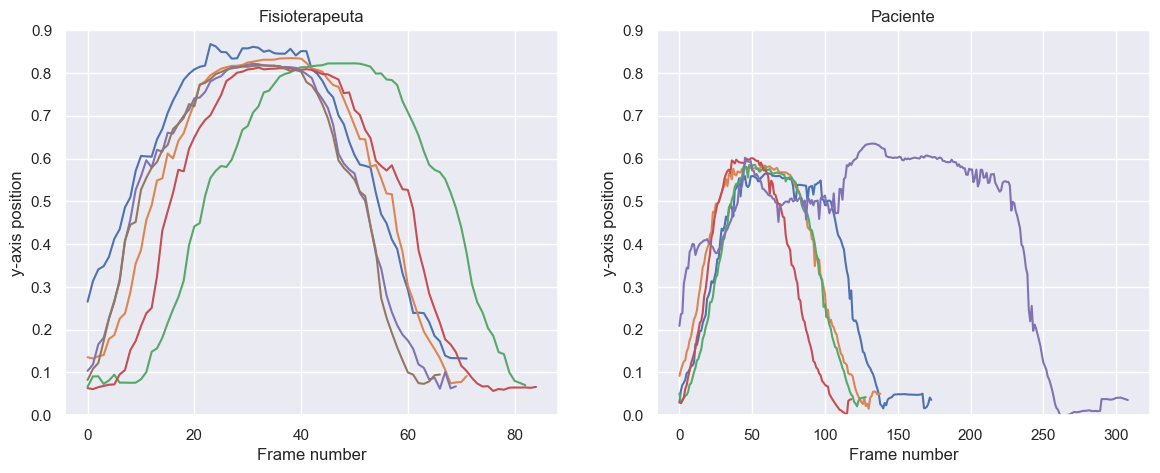

In [7]:
# creamos una gráfica para cada persona
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('Fisioterapeuta')
repetition_graph(persona_sana, 'WristRight', '3D_Y')

plt.subplot(1, 2, 2)
plt.title('Paciente')
repetition_graph(paciente_206, 'WristRight', '3D_Y')

plt.show()

****
## 2. Numero de instancias correctas e incorrectas

*CorrectLabel*: Etiqueta que indica si el gesto ha sido clasificado como correcto. Tiene tres posibles valores: 1 (ejecutado correctamente), 2 (ejecutado incorrectamente) y 3 (ejecutado de manera deficiente)

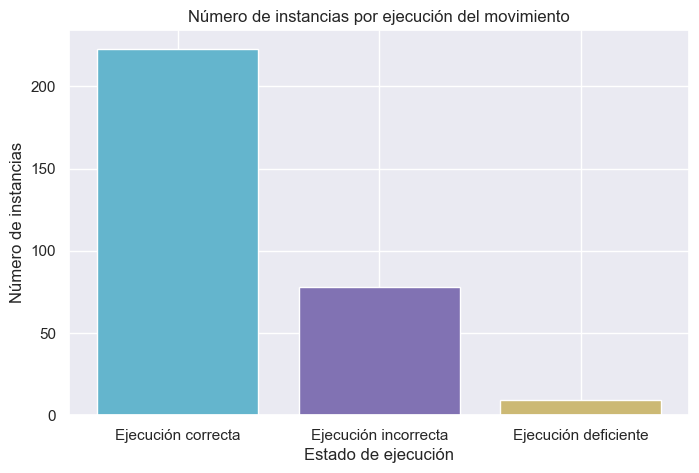

In [8]:
# Selecciona las columnas de interés y elimina duplicados
df_peque = df_data[['SubjectID', 'GestureLabel', 'CorrectLabel']].drop_duplicates().reset_index(drop=True)

# Agrupa el DataFrame y cuenta el número de gestos por cada categoría
df_peque = df_peque.groupby(['CorrectLabel']).count()

# Definición de las etiquetas y colores para la gráfica
x = ["Ejecución correcta", "Ejecución incorrecta", "Ejecución deficiente"]
color = ['c', 'm', 'y']

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(x, df_peque['GestureLabel'].values, color=color)

# Etiquetar los ejes
plt.ylabel('Número de instancias')
plt.xlabel('Estado de ejecución')
plt.title('Número de instancias por ejecución del movimiento')
plt.show()

****
## 3. Sujetos por gesto

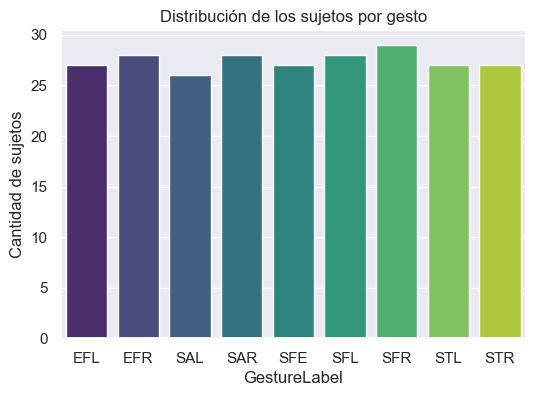

In [9]:
subject_per_gesture = df_data.groupby("GestureName")["SubjectID"].nunique().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(6, 4))
ax = sns.barplot(x="GestureName", y="SubjectID", data=subject_per_gesture, palette="viridis")

# Añadir título y etiquetas a los ejes
ax.set_title("Distribución de los sujetos por gesto")
ax.set_xlabel("GestureLabel")
ax.set_ylabel("Cantidad de sujetos")
plt.show()

*****
# 4. Sujetos por gesto y estado de ejecución

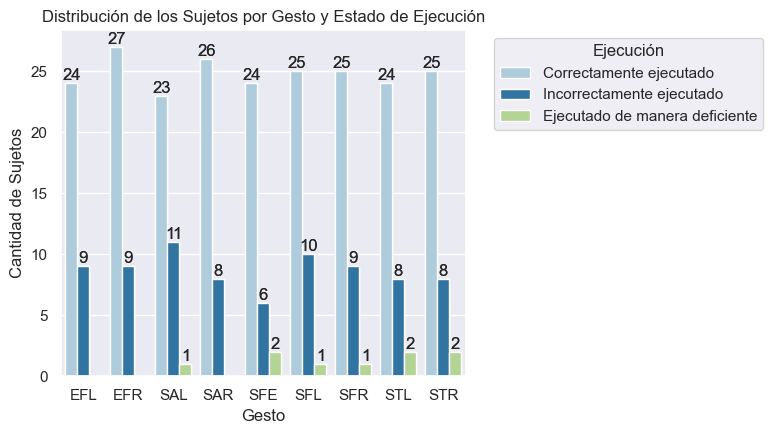

In [10]:
subject_count_per_gesture_correct = df_data.groupby(["GestureName", "CorrectLabel"])["SubjectID"].nunique().reset_index()

# Plotting
plt.figure(figsize=(8, 4.5))
ax = sns.barplot(x="GestureName", y="SubjectID", hue="CorrectLabel",
                 data=subject_count_per_gesture_correct, palette="Paired")

# Crear el gráfico de barras con la separación por estado de ejecución (hue)
ax = sns.barplot(x="GestureName", y="SubjectID", hue="CorrectLabel",
                 data=subject_count_per_gesture_correct, palette="Paired")

# Añadir título y etiquetas a los ejes
ax.set_title("Distribución de los Sujetos por Gesto y Estado de Ejecución")
ax.set_xlabel("Gesto")
ax.set_ylabel("Cantidad de Sujetos")

# Modificar las etiquetas de la leyenda
legend_labels = ['Correctamente ejecutado',
                 'Incorrectamente ejecutado',
                 'Ejecutado de manera deficiente']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=legend_labels,
          title='Ejecución', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadir etiquetas a las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
    
plt.tight_layout()
plt.show()

****
## 5. Ángulos a través de tiempo

In [11]:
persona104_right = extraer_persona(df_angle, '104', ['1', '3', '5', '6'])

In [12]:
# Función para crear la gráfica
def angle_graph(df:pd.DataFrame, angle:str):
    """
    Crea gráficos de líneas para representar la variación de un ángulo específico a lo largo del tiempo
    (frames) para cada gesto. Cada subgráfico representa un gesto distinto.
    
    Parámetros
    --------
    df : DataFrame
        Contiene datos sobre los ángulos y los gestos.
    angle : str
        Nombre de la columna en el DataFrame que contiene los valores del ángulo a graficar.
    """
    # Agrupar el DataFrame por gesto 
    groups = df.groupby(["GestureName"]) 
    n_angles = len(groups)

    # Crear una figura con un subgráfico por cada gesto
    _, axes = plt.subplots(n_angles, 1, figsize=(10, 3*n_angles), constrained_layout=True)

    for ax, (gesture_name, group) in zip(axes, groups):

        group = group.reset_index(drop=True) 
        sns.lineplot(data=group, x=group.index, y=angle, hue='RepetitionNumber', ax=ax,
                     palette='flare', legend=False)
        
        # Configurar etiquetas y título para cada subgráfico
        ax.set_xlabel("Frame")
        ax.set_ylabel("Ángulo")
        ax.set_title(f'Gesto id: {gesture_name.}')
        ax.set_ylim(10, 175) 

    plt.tight_layout()  
    plt.show()  

C:\Users\nerea\AppData\Local\Temp\ipykernel_15912\684751552.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


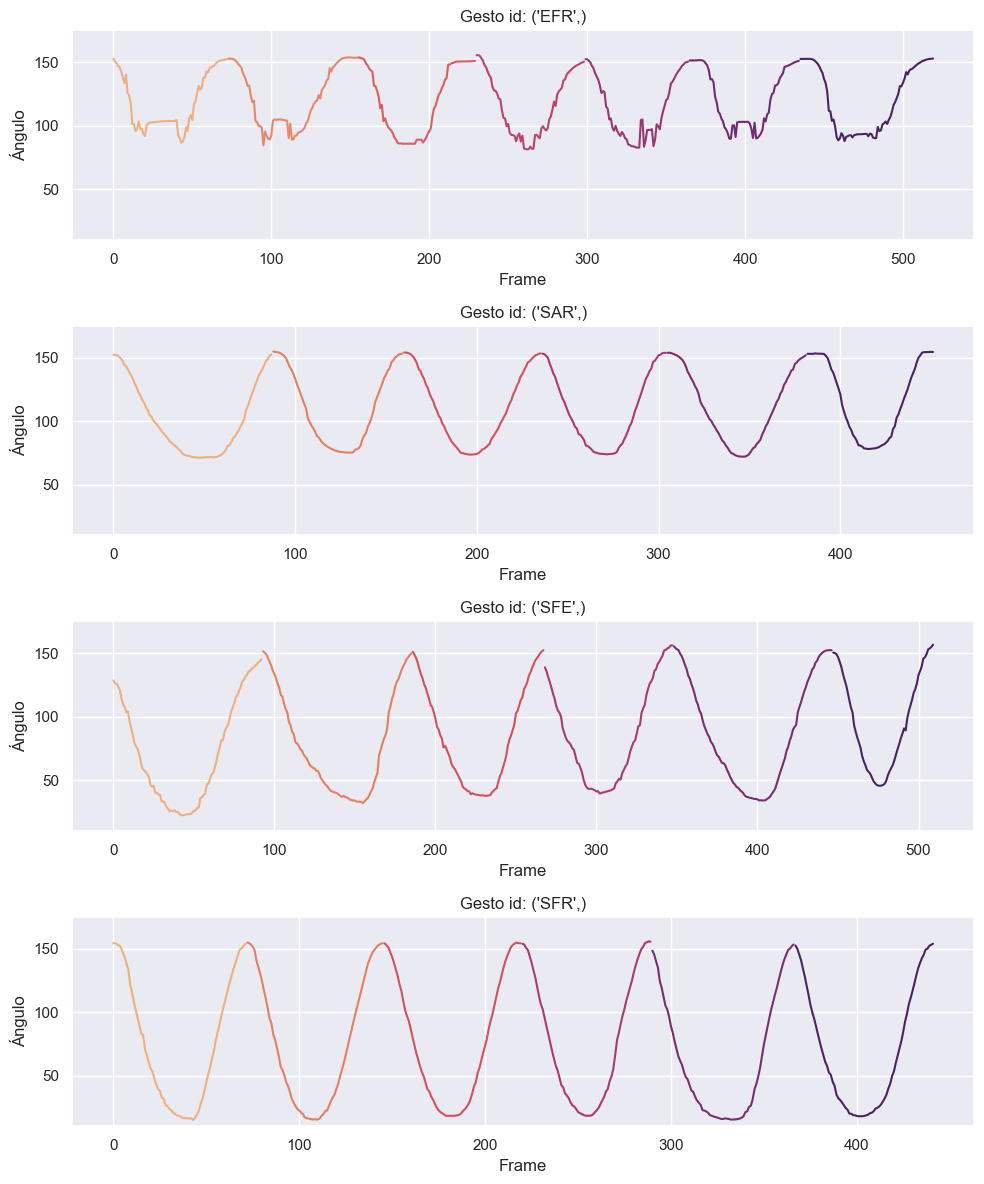

In [13]:
angle_graph(persona104_right, 'ArmsTogetherAngle')